In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate, cross_val_predict

In [2]:
# Load dataset
data = pd.read_csv("data/processed/fraud.csv")

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)


In [3]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 9252
Validation size: 3084
Test size: 3084


In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),              
    ('resample', SMOTEENN(random_state=42)),  
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
    ))
])

In [5]:
param_dist = {
    'xgb__n_estimators': randint(300, 800),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__gamma': uniform(0, 0.5)
}

In [6]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)
scoring = pr_auc_scorer

In [7]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [8]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV PR-AUC: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\DSA4263\venv-dsa4263\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


Best Parameters: {'xgb__colsample_bytree': np.float64(0.749816047538945), 'xgb__gamma': np.float64(0.4753571532049581), 'xgb__learning_rate': np.float64(0.15639878836228102), 'xgb__max_depth': 7, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 402, 'xgb__subsample': np.float64(0.7783331011414365)}
Best CV PR-AUC: nan


In [9]:
cv_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, response_method="predict_proba"),
    'pr_auc': make_scorer(average_precision_score, response_method="predict_proba")   
}

cv_results = cross_validate(
    random_search.best_estimator_,
    X_train,
    y_train,
    scoring=cv_scoring,
    cv=5
)


In [10]:
metric_table = pd.DataFrame(cv_results)

In [11]:
metric_table

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc
0,0.852224,0.036503,0.916802,0.340741,0.414414,0.373984,0.884726,0.320200
1,0.860929,0.028214,0.924905,0.383333,0.414414,0.398268,0.909982,0.358979
2,0.888474,0.025297,0.921622,0.355372,0.390909,0.372294,0.895998,0.350816
3,0.893455,0.025389,0.925946,0.387931,0.405405,0.396476,0.901745,0.366710
4,0.892828,0.025385,0.928649,0.403670,0.396396,0.400000,0.906646,0.400114


In [12]:
print("\nMean Recall across folds:", metric_table['test_recall'].mean())


Mean Recall across folds: 0.4043079443079443


In [13]:
print("\nMean Precision across folds:", metric_table['test_precision'].mean())


Mean Precision across folds: 0.3742093468307842


In [14]:
print("\nMean Precision across folds:", metric_table['test_pr_auc'].mean())


Mean Precision across folds: 0.35936376009132254


In [15]:
y_pred_cv = cross_val_predict(
    random_search.best_estimator_,
    X_train, y_train,
    cv=5,
    method='predict'
)
cm = confusion_matrix(y_train, y_pred_cv)
print(cm)


[[8321  377]
 [ 330  224]]


In [16]:
print(classification_report(y_train, y_pred_cv))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8698
           1       0.37      0.40      0.39       554

    accuracy                           0.92      9252
   macro avg       0.67      0.68      0.67      9252
weighted avg       0.93      0.92      0.93      9252



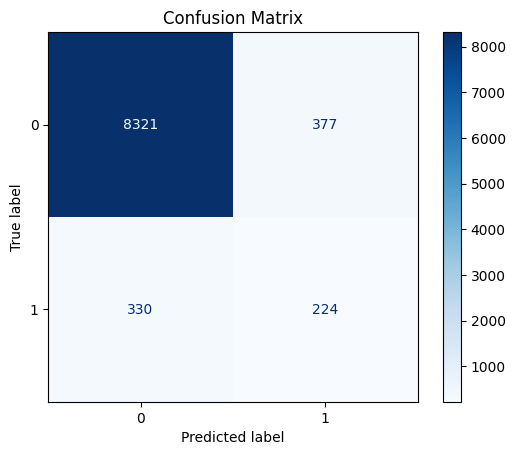

In [17]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix")
plt.show()

In [18]:
best_model = random_search.best_estimator_
y_prob = best_model.predict_proba(X_val)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
print(f"Val Recall: {recall_score(y_val, y_pred):.4f}")
val_pr_auc = average_precision_score(y_val, y_prob)
print("Val PR-AUC:", val_pr_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=4))

Val Recall: 0.4946
Val PR-AUC: 0.3748899752635227
[[2776  124]
 [  93   91]]
              precision    recall  f1-score   support

           0     0.9676    0.9572    0.9624      2900
           1     0.4233    0.4946    0.4561       184

    accuracy                         0.9296      3084
   macro avg     0.6954    0.7259    0.7093      3084
weighted avg     0.9351    0.9296    0.9322      3084



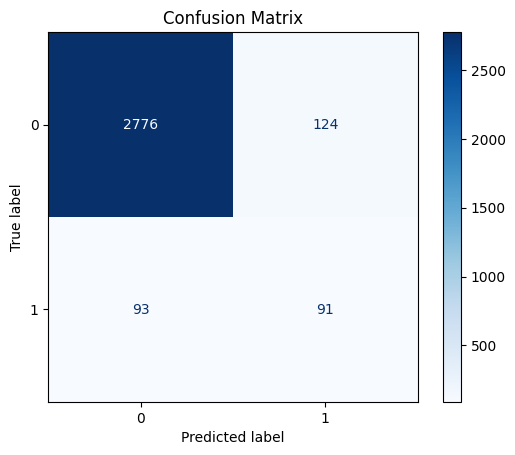

In [19]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix")
plt.show()

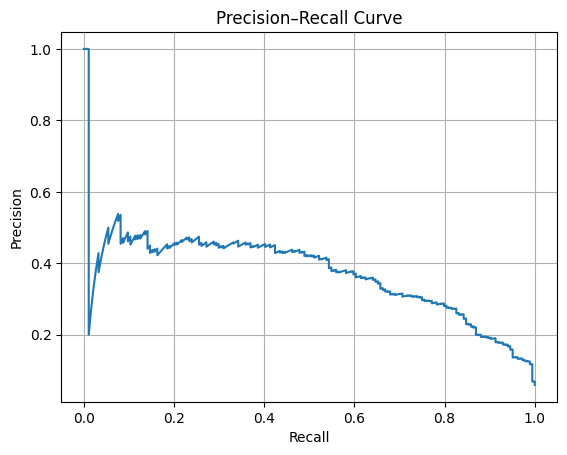

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()
